# Assignment 2 - Image Captioning

This notebook contains the required task for the second assignment of the Deep Network Development course. Read the task description and fill in the empty code cells. Each section represents an implementation stage of image captioning : -from loading and inspecting the dataset; -to implementing, training and evaluating an Encoder-Decoder + Attention based architecture. The sections are there to guide you but you do not have to follow them strictly.

Copy this notebook to your drive (File -> Save a copy in Drive), edit it, and upload the final .ipynb file to [Canvas](https://canvas.elte.hu). If you are using this in Google Colab notebook, save it as .ipynb and upload it, or share the public link. If you have your own machine with Jupyter installed, you can work there as well, as long as you save and upload the .ipynb file.


## General Rules
Please check all the requirements listed on Canvas, but here are some general rules:
- From the provided Flickr8k dataset, split it into train, val and test sets;
- Use the train set to train an Image Captioning model, the val set for validation of the model and hyper-parameters, and the test set to evaluate the final trained model;
- For this assignment, we will give importance to the performance of your model, meaning that, we will evaluate if your model is overfitted or underfitted. For that, please include visualizations (print and plot) loss values for the split sets, as well as the metric results;
- For the metric, while we do not require high performance, we still expect better than random guessing results;
- For the comparison, you are free to choose any pre-trained model;
- Copying others' code will make you fail the assignment automatically, resulting in a 0;
- Not submitting anything results in a 0;
- Submitting something, as long as it is not an empty notebook, might result in a 1;
- **Deadline is November 29th 11:59 PM** (strict, no late submission);
- Feel free to add more code cells as needed. But don't put code into external Python files;
- Please add your name, **Neptun ID**, and task details below.

**Name: Mir Mohibullah Sazid** 

**Neptun ID: GVFPV8**

## Task description

Your task is to train your own custom image captioning model and compare its performance with an existing (pre-trained) model. For that, first you need to load the provided Flickr8k dataset, split into train, val and test sets. Then, create your own architecture, which should follow an Encoder-Decoder + Attention sturcture. You can use pre-trained backbones (i.e. ResNet) for the encoder, but they have to be fine-tuned. We expect you to use an Attention layer, in order to visualize how the network learned (see more details on section 2 of the notebook).
There is no expected high performance, but **your metrics should show results better than random guessing and your loss has to decrease throughout the epochs. Please use BLEU score as the metric**. We expect you to **show visualizations (prints and plots)** of the **metrics, losses, and predictions**. Use techniques to avoid overfitting such as Early stopping, and more, and save the best model while training your architecture.

**In order to get your grade for the assignment, you must defend it by answering questions during the designated practice time.**

## Guidelines
Please carefully read each cell of the notebook, as they contain guidelines to help you complete the assignments. While you don't have to follow them strictly, we believe that they provide enough help.

# 0. Necessary Imports
Import all the necessary packages for this assignment. **ONLY PYTORCH MODELS ARE ACCEPTED!**

# 1. DATASET
For this assignment you will be using the [Flickr8k](https://www.kaggle.com/datasets/adityajn105/flickr8k) dataset, which contains captions/descriptions of different images.

### 1.1. Download dataset
The best way to download this dataset is through Kaggle.
First create a token, download it and upload it here. Follow these steps: https://www.kaggle.com/discussions/general/74235

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("adityajn105/flickr8k")

print("Path to dataset files:", path)

### 1.2. Load dataset
In order to load the dataset, you need to create a pytorch Dataset class.
The class should return images and captions. Remember that the captions should be returned as tokens. Do not forget to include the SOS:start of sentence, EOS:end of sentence and UNK:unknown tokens. You may want to build a vocabulary class in order to save all the words in your dataset, because your model can only predict words in your vocabulary. You do not have to save every word in your vocabulary, it is common practice to save only those words that appear multiple times in your whole dataset. For example, save only words that appear at least 5 times in your whole dataset.

Split your dataset into train, val and test sets

Create a dataloader, in order to load the examples in batches. Remember that, a batch has different examples, and each example (caption) may have different sizes. Therefore, consider padding techniques for the captions. For the image, use transforms in the previous step, to ensure same format and size.  

In [ ]:
import pandas as pd
from torch.utils.data import Dataset, DataLoader, random_split
from torch.nn.utils.rnn import pad_sequence
import os
import torch
from torchvision import transforms
import spacy
from collections import Counter
from PIL import Image

# Load English tokenizer from spacy
spacy_eng = spacy.load("en_core_web_sm")

class Vocabulary:
    def __init__(self, freq_threshold):
        self.freq_threshold = freq_threshold
        self.itos = {0: "<PAD>", 1: "<SOS>", 2: "<EOS>", 3: "<UNK>"}
        self.stoi = {"<PAD>": 0, "<SOS>": 1, "<EOS>": 2, "<UNK>": 3}
        self.index_to_vocab = {0: "<PAD>", 1: "<SOS>", 2: "<EOS>", 3: "<UNK>"}

    def __len__(self):
        return len(self.itos)

    @staticmethod
    def tokenize(text):
        return [tok.text.lower() for tok in spacy_eng.tokenizer(text) if tok.is_alpha]

    def build_vocabulary(self, sentence_list):
        frequencies = Counter()
        idx = 4

        for sentence in sentence_list:
            for word in self.tokenize(sentence):
                frequencies[word] += 1

                if frequencies[word] == self.freq_threshold:
                    self.stoi[word] = idx
                    self.itos[idx] = word
                    self.index_to_vocab[idx] = word  # this line to maintain the reverse mapping
                    idx += 1

    def numericalize(self, text):
        tokenized_text = self.tokenize(text)
        return [self.stoi.get(token, self.stoi["<UNK>"]) for token in tokenized_text]


class FlickrDataset(Dataset):
    def __init__(self, root_dir, captions_file, transform=None, freq_threshold=5):
        """
        Initialize the FlickrDataset with Vocabulary integration.
        """
        self.root_dir = root_dir
        self.df = pd.read_csv(captions_file)
        self.transform = transform
        self.images = self.df['image']
        self.captions = self.df['caption']

        # Initialize and build the vocabulary
        self.vocab = Vocabulary(freq_threshold)
        self.vocab.build_vocabulary(self.captions.tolist())

        # Vectorize captions
        self.caption_vector = self.vectorize_caption()

    def vectorize_caption(self):
        """
        Convert captions to numerical format using the vocabulary.
        """
        caption_vector = []
        for caption in self.captions:
            caption_vec = [self.vocab.stoi["<SOS>"]] + \
                          self.vocab.numericalize(caption) + \
                          [self.vocab.stoi["<EOS>"]]
            caption_vector.append(caption_vec)
        return caption_vector

    def __len__(self):
        """
        Return the size of the dataset.
        """
        return len(self.images)

    def __getitem__(self, idx):
        """
        Get an item from the dataset.
        """
        img_id = self.images[idx]
        img_path = os.path.join(self.root_dir, img_id)

        # Load and transform the image
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)

        # Numericalized caption for the current index
        caption_vec = self.caption_vector[idx]

        # All captions related to the same image
        all_captions = self.df[self.df['image'] == img_id]['caption'].tolist()
        all_caption_vectors = [
            [self.vocab.stoi["<SOS>"]] +
            self.vocab.numericalize(caption) +
            [self.vocab.stoi["<EOS>"]]
            for caption in all_captions
        ]

        return image, torch.tensor(caption_vec), all_caption_vectors


# Define transformations
train_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomCrop((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_test_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.CenterCrop((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

def collate_fn(batch):
    """
    Custom collate function to handle variable-length captions.
    """
    images = [item[0] for item in batch]
    captions = [item[1] for item in batch]
    all_captions = [item[2] for item in batch]

    # Pad captions to the maximum length in the batch
    captions_padded = pad_sequence(captions, batch_first=True, padding_value=dataset.vocab.stoi["<PAD>"])
    
    return torch.stack(images), captions_padded, all_captions


root_dir = "/home/sazid/Documents/semester3/DND Ass 2/adityajn105/flickr8k/versions/1/Images"
captions_file = "/home/sazid/Documents/semester3/DND Ass 2/adityajn105/flickr8k/versions/1/captions.txt"

# Initialize dataset
dataset = FlickrDataset(root_dir=root_dir, captions_file=captions_file, transform=train_transform)

# Manually splitting dataset
train_size = int(0.8 * len(dataset))
val_size = int(0.15 * len(dataset))
test_size = len(dataset) - train_size - val_size

train_dataset = torch.utils.data.Subset(dataset, range(train_size))
val_dataset = torch.utils.data.Subset(dataset, range(train_size, train_size + val_size))
test_dataset = torch.utils.data.Subset(dataset, range(train_size + val_size, len(dataset)))

# Apply transformations for each split
train_dataset.dataset.transform = train_transform
val_dataset.dataset.transform = val_test_transform
test_dataset.dataset.transform = val_test_transform

# Create DataLoaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)


print(f"Training Set Size: {len(train_dataset)}")
print(f"Validation Set Size: {len(val_dataset)}")
print(f"Test Set Size: {len(test_dataset)}")
print("vocabulary size:", len(dataset.vocab))
# Example usage
for imgs, captions, all_captions in train_loader:
    print(f"Images shape: {imgs.shape}")
    print(f"Captions shape: {captions.shape}")
    print(f"All captions (first example): {all_captions[0]}")
    break


Training Set Size: 32364
Validation Set Size: 6068
Test Set Size: 2023
vocabulary size: 2974
Images shape: torch.Size([32, 3, 224, 224])
Captions shape: torch.Size([32, 26])
All captions (first example): [[1, 4, 1676, 16, 573, 4, 808, 1624, 2], [1, 4, 310, 77, 4, 20, 319, 81, 16, 106, 39, 193, 1556, 2], [1, 4, 1681, 449, 664, 4, 494, 71, 101, 9, 175, 11, 792, 58, 225, 2], [1, 4, 13, 16, 1105, 100, 58, 175, 327, 101, 171, 9, 1834, 98, 347, 440, 4, 106, 1624, 2], [1, 4, 54, 573, 4, 3, 218, 494, 39, 193, 2571, 2]]


Example output from dataset class

Token for the word 'climbing': 31
Images batch shape: torch.Size([32, 3, 224, 224])
Captions batch shape: torch.Size([32, 20])
Tokenized Caption: [1, 4, 1047, 10, 66, 405, 18, 4, 362, 7, 4, 1949, 2, 0, 0, 0, 0, 0, 0, 0]
Decoded Sentence: a bunch of people drinking at a bar in a club
--------------------------------------------------
Tokenized Caption: [1, 192, 8, 6, 12, 4, 1378, 162, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Decoded Sentence: smiling little girl on a carnival ride
--------------------------------------------------
Tokenized Caption: [1, 4, 8, 42, 7, 4, 20, 324, 1574, 319, 81, 115, 12, 4, 381, 2, 0, 0, 0, 0]
Decoded Sentence: a little boy in a white long sleeved t shirt jumps on a trampoline
--------------------------------------------------


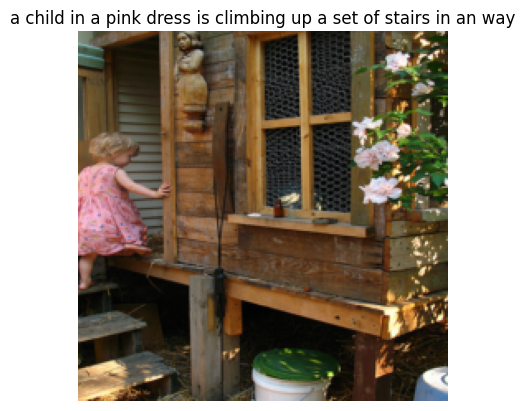

Tokenized Caption: [1, 4, 27, 7, 4, 191, 148, 16, 31, 65, 4, 349, 10, 706, 7, 23, 3, 491, 2]
Decoded Sentence: a child in a pink dress is climbing up a set of stairs in an way
Original Caption: A child in a pink dress is climbing up a set of stairs in an entry way .
Tokenized: [1, 4, 27, 7, 4, 191, 148, 16, 31, 65, 4, 349, 10, 706, 7, 23, 3, 491, 2]
--------------------------------------------------


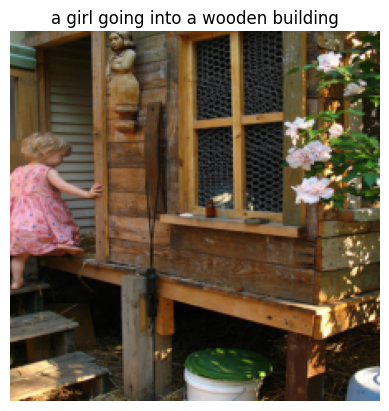

Tokenized Caption: [1, 4, 6, 312, 74, 4, 154, 72, 2]
Decoded Sentence: a girl going into a wooden building
Original Caption: A girl going into a wooden building .
Tokenized: [1, 4, 6, 312, 74, 4, 154, 72, 2]
--------------------------------------------------


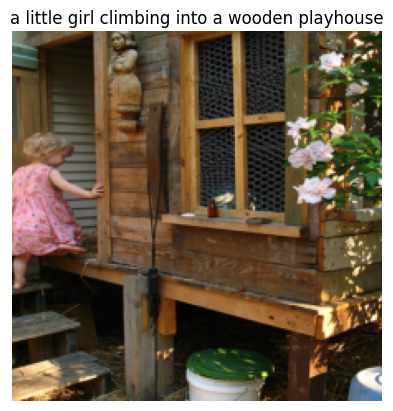

Tokenized Caption: [1, 4, 8, 6, 31, 74, 4, 154, 2390, 2]
Decoded Sentence: a little girl climbing into a wooden playhouse
Original Caption: A little girl climbing into a wooden playhouse .
Tokenized: [1, 4, 8, 6, 31, 74, 4, 154, 2390, 2]
--------------------------------------------------


In [3]:
import matplotlib.pyplot as plt

def decode_caption(tokens, vocab):
    """
    Decodes a list of token IDs into a readable caption.
    Removes special tokens like <PAD>, <SOS>, <EOS>, and <UNK>.
    """
    words = [
        vocab.index_to_vocab[token]  # Use index_to_vocab instead of stoi for decoding
        for token in tokens 
        if token not in {vocab.stoi["<PAD>"], vocab.stoi["<SOS>"], vocab.stoi["<EOS>"], vocab.stoi["<UNK>"]}
    ]
    return " ".join(words)

# Fetch the token for a specific word
word_to_check = "climbing"
word_token = dataset.vocab.stoi.get(word_to_check)  # Access vocab from the dataset

print(f"Token for the word '{word_to_check}': {word_token}")

# Fetch a batch of data
for imgs, captions, _ in train_loader:
    print("Images batch shape:", imgs.shape)
    print("Captions batch shape:", captions.shape)

    # Print a few examples
    for i in range(3):
        tokens = captions[i].tolist()  # Convert tensor to list of tokens
        decoded_sentence = decode_caption(tokens, dataset.vocab)  # Decode using vocab from dataset
        print("Tokenized Caption:", tokens)
        print("Decoded Sentence:", decoded_sentence)
        print('-' * 50)
    break  # Just displaying the first batch

def show_image(img, title=None):
    """
    Display an image with an optional title.
    """
    img = img.permute(1, 2, 0).cpu().numpy()  # Convert to numpy array for visualization
    img = img * [0.229, 0.224, 0.225] + [0.485, 0.456, 0.406]  # Unnormalize
    img = img.clip(0, 1)  # Clip values to [0, 1]
    plt.imshow(img)
    if title:
        plt.title(title)
    plt.axis('off')
    plt.show()

def visualize_samples(dataset, num_samples=3):
    """
    Visualize a few samples from the dataset with their captions.
    """
    for i in range(num_samples):
        img, caps, _ = dataset[i]
        sentence = decode_caption(caps.tolist(), dataset.vocab)  # Decode caption using the vocabulary
        show_image(img, title=sentence)
        print("Tokenized Caption:", caps.tolist())  # Display tokenized caption
        print("Decoded Sentence:", sentence)
        print("Original Caption:", dataset.df.iloc[i]['caption'])  # Original caption from the dataframe
        print("Tokenized:", dataset.caption_vector[i])  # Display tokenized caption vector
        print('-' * 50)

# Visualize samples
visualize_samples(dataset, num_samples=3)


#2. MODEL
For this assignment, you are required to create your own custom image captioning model and compare its performance with an existing pre-trained model.

### 2.1. Custom Image Captioning model

Create an Encoder-Attention-Decoder architecture with the following details:
- the encoder should process the images, thus you can create a Convolutional based architecture or use already pre-trained models like ResNet. However, you must fine-tune the pretrained model. The encoder is responisble for extracting image features;
- the attention layer should be between the encoder and decoder. It uses the image features from the encoder in order to provide context (attention scores) to the decoder hidden layers. For simplicity use Linear layers as the attention architecture;
- the decoder should be a sequence based model (i.e. LSTM) in order to process and generate captions.

Extra:
- Extra points (counting toward the final grade) will be given to any student who implements either a Vision-based Transformer architecture or a Transformer only decoder for the decoder part.

#### Reference
Here is an example of something similar to what we want to create:
<img src="https://drive.google.com/thumbnail?id=1wdddaLit7iEyCcVy5bS505NiYzL6c-4x&sz=w1000">


In [4]:
import torch
torch.cuda.empty_cache()


In [5]:
import gc

# Run garbage collector
gc.collect()

# Clear GPU cache
torch.cuda.empty_cache()


In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.cuda.amp import autocast, GradScaler
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import os

class Encoder(nn.Module):
    def __init__(self, embed_size):
        super(Encoder, self).__init__()
        resnet = models.resnet50(pretrained=True)
        self.resnet = nn.Sequential(*list(resnet.children())[:-2])
        self.adaptive_pool = nn.AdaptiveAvgPool2d((7, 7))
        self.fc = nn.Linear(2048, embed_size)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.5)
        
        # Allow fine-tuning of the ResNet model
        for param in self.resnet.parameters():
            param.requires_grad = True

    def forward(self, images):
        features = self.resnet(images)  # (batch_size, 2048, 7, 7)
        features = self.adaptive_pool(features)
        features = features.view(features.size(0), -1, features.size(1))  # (batch_size, 49, 2048)
        features = self.fc(features)  # (batch_size, 49, embed_size)
        return self.dropout(self.relu(features))
class Attention(nn.Module):
    def __init__(self, encoder_dim, decoder_dim, attention_dim):
        super(Attention, self).__init__()
        self.encoder_att = nn.Linear(encoder_dim, attention_dim)  # Linear layer to transform encoder outputs
        self.decoder_att = nn.Linear(decoder_dim, attention_dim)  # Linear layer to transform decoder hidden state
        self.full_att = nn.Linear(attention_dim, 1)  # Linear layer to compute attention score
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax(dim=1)
    
    def forward(self, encoder_outputs, decoder_hidden):
        """
        Computes the attention weights and context vector.
        - encoder_outputs: (batch_size, num_pixels, encoder_dim)
        - decoder_hidden: (batch_size, decoder_dim)
        """
        # Transform encoder outputs and decoder hidden state
        att1 = self.encoder_att(encoder_outputs)  # (batch_size, num_pixels, attention_dim)
        att2 = self.decoder_att(decoder_hidden).unsqueeze(1)  # (batch_size, 1, attention_dim)

        # Compute attention scores
        att = self.full_att(self.relu(att1 + att2)).squeeze(2)  # (batch_size, num_pixels)
        alpha = self.softmax(att)  # (batch_size, num_pixels)

        # Reshape attention weights if necessary
        if len(alpha.shape) == 1:
            alpha = alpha.unsqueeze(1)

        # Ensure alpha has shape (batch_size, 49)
        if alpha.shape[1] != encoder_outputs.shape[1]:
            print(f"Attention shape mismatch: {alpha.shape[1]} != {encoder_outputs.shape[1]}")
            alpha = torch.ones(encoder_outputs.shape[0], encoder_outputs.shape[1]).to(encoder_outputs.device)

        # Calculate the context vector as a weighted sum of encoder outputs
        context = (encoder_outputs * alpha.unsqueeze(2)).sum(dim=1)  # (batch_size, encoder_dim)
        return context, alpha
class DecoderWithAttention(nn.Module):
    def __init__(self, embed_size, vocab_size, encoder_dim, decoder_dim, attention_dim, num_layers=1, dropout=0.5):
        super(DecoderWithAttention, self).__init__()
        self.attention = Attention(encoder_dim, decoder_dim, attention_dim)
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.lstm = nn.LSTM(embed_size + encoder_dim, decoder_dim, num_layers, batch_first=True, dropout=dropout)
        self.fc = nn.Linear(decoder_dim, vocab_size)
        self.dropout = nn.Dropout(dropout)
    
    def forward(self, encoder_outputs, captions):
        batch_size = encoder_outputs.size(0)
        seq_length = captions.size(1)
        num_pixels = encoder_outputs.size(1)

        embeddings = self.dropout(self.embedding(captions))
        h, c = torch.zeros(1, batch_size, encoder_outputs.size(2)).to(captions.device), torch.zeros(1, batch_size, encoder_outputs.size(2)).to(captions.device)
        outputs = torch.zeros(batch_size, seq_length, self.fc.out_features).to(captions.device)

        attention_weights = torch.zeros(batch_size, seq_length, num_pixels).to(captions.device)

        for t in range(seq_length):
            context, alpha = self.attention(encoder_outputs, h[-1])
            
            # Ensure alpha has the expected shape
            if alpha.shape[1] != num_pixels:
                print(f"Inconsistent alpha shape: {alpha.shape}")
            
            attention_weights[:, t, :] = alpha
            lstm_input = torch.cat([embeddings[:, t, :], context], dim=1).unsqueeze(1)
            _, (h, c) = self.lstm(lstm_input, (h, c))
            outputs[:, t, :] = self.fc(h[-1])

        return outputs, attention_weights

Combine the encoder - attention - decoder

In [7]:
class ImageCaptioningModel(nn.Module):
    def __init__(self, embed_size, vocab_size, encoder_dim, decoder_dim, attention_dim):
        super(ImageCaptioningModel, self).__init__()
        self.encoder = Encoder(embed_size)
        self.decoder = DecoderWithAttention(embed_size, vocab_size, encoder_dim, decoder_dim, attention_dim)
    
    def forward(self, images, captions):
        features = self.encoder(images)
        outputs, attention_weights = self.decoder(features, captions)
        return outputs, attention_weights

In [ ]:
import torchvision.models as models

# Define the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vocab_size = len(dataset.vocab)

# Define the model parameters
embed_size = 256
encoder_dim = 256
decoder_dim = 256
attention_dim = 128

# Initialize the model
model = ImageCaptioningModel(embed_size, vocab_size, encoder_dim, decoder_dim, attention_dim).to(device)

# Create a random batch of images and captions for testing
batch_size = 2
seq_length = 20  

# Sample input data
images = torch.randn(batch_size, 3, 224, 224).to(device)  # Random images
captions = torch.randint(0, vocab_size, (batch_size, seq_length)).to(device)  # Random captions

# Forward pass through the model
model.eval()
with torch.no_grad():
    outputs, attention_weights = model(images, captions)

# Print the output shapes
print("Images shape:", images.shape)        # Expected: (batch_size, 3, 224, 224)
print("Captions shape:", captions.shape)    # Expected: (batch_size, seq_length)
print("Outputs shape:", outputs.shape)      # Expected: (batch_size, seq_length, vocab_size)
print("Attention weights shape:", attention_weights.shape)  # Expected: (batch_size, seq_length, num_pixels)

Images shape: torch.Size([2, 3, 224, 224])
Captions shape: torch.Size([2, 20])
Outputs shape: torch.Size([2, 20, 2974])
Attention weights shape: torch.Size([2, 20, 49])


### 2.2. Training custom model

### Important: we recommend saving the model during training, so that you can resume training later in case of any Google Colab issue or limitation

Pay attention to your choices. Define an optimizer, a loss function, the number of epochs and regularization techniques.
Be aware of overfitting and underfitting. Make sure the loss is decreasing over the epochs. Save the losses so that they can be visualized.

In [10]:

import torch.optim as optim
import torch.nn as nn
import matplotlib.pyplot as plt
import os
# Hyperparameters
embed_size = 256
vocab_size = len(dataset.vocab)  # Get vocab size from the dataset
encoder_dim = 256
decoder_dim = 256
attention_dim = 128
learning_rate = 1e-4
num_epochs = 50
batch_size = 32
checkpoint_path = "Test.pth"

# Initialize model, optimizer, and loss function
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ImageCaptioningModel(embed_size, vocab_size, encoder_dim, decoder_dim, attention_dim).to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)
criterion = nn.CrossEntropyLoss(ignore_index=dataset.vocab.stoi["<PAD>"])

# Gradient Scaler for mixed precision training
scaler = torch.cuda.amp.GradScaler()

# Create directory for saving models
if not os.path.exists('checkpoints'):
    os.makedirs('checkpoints')




Visualize the attention weigths in order to understand how your model learned (**Failure to do this, will result in losing points**).
For that, use the 'context' variable returned by the Attention class to overlay them on the image.

Epoch 1/50:   0%|          | 0/1012 [00:00<?, ?batch/s]/tmp/ipykernel_5958/2625374880.py:68: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 1/50: 100%|██████████| 1012/1012 [03:50<00:00,  4.40batch/s, train_loss=4.61]


Epoch [1/50] - Training Loss: 4.9494


Epoch [1/50] - Validation Loss: 4.3569
Checkpoint saved at epoch 1
New best model saved with validation loss: 4.3569
Checkpoint saved at epoch 1


Epoch 2/50: 100%|██████████| 1012/1012 [03:52<00:00,  4.36batch/s, train_loss=3.82]


Epoch [2/50] - Training Loss: 4.1637


Epoch [2/50] - Validation Loss: 3.9384
Checkpoint saved at epoch 2
New best model saved with validation loss: 3.9384
Checkpoint saved at epoch 2


Epoch 3/50: 100%|██████████| 1012/1012 [03:52<00:00,  4.35batch/s, train_loss=3.9] 


Epoch [3/50] - Training Loss: 3.8464


Epoch [3/50] - Validation Loss: 3.6899
Checkpoint saved at epoch 3
New best model saved with validation loss: 3.6899
Checkpoint saved at epoch 3


Epoch 4/50: 100%|██████████| 1012/1012 [03:52<00:00,  4.36batch/s, train_loss=3.87]


Epoch [4/50] - Training Loss: 3.6269


Epoch [4/50] - Validation Loss: 3.5102
Checkpoint saved at epoch 4
New best model saved with validation loss: 3.5102
Checkpoint saved at epoch 4


Epoch 5/50: 100%|██████████| 1012/1012 [03:51<00:00,  4.36batch/s, train_loss=3.55]


Epoch [5/50] - Training Loss: 3.4588


Epoch [5/50] - Validation Loss: 3.3741
Checkpoint saved at epoch 5
New best model saved with validation loss: 3.3741
Checkpoint saved at epoch 5


Epoch 6/50: 100%|██████████| 1012/1012 [03:52<00:00,  4.36batch/s, train_loss=3.54]


Epoch [6/50] - Training Loss: 3.3280


Epoch [6/50] - Validation Loss: 3.2693
Checkpoint saved at epoch 6
New best model saved with validation loss: 3.2693
Checkpoint saved at epoch 6


Epoch 7/50: 100%|██████████| 1012/1012 [03:51<00:00,  4.36batch/s, train_loss=3.55]


Epoch [7/50] - Training Loss: 3.2170


Epoch [7/50] - Validation Loss: 3.1825
Checkpoint saved at epoch 7
New best model saved with validation loss: 3.1825
Checkpoint saved at epoch 7


Epoch 8/50: 100%|██████████| 1012/1012 [03:52<00:00,  4.34batch/s, train_loss=3.05]


Epoch [8/50] - Training Loss: 3.1225


Epoch [8/50] - Validation Loss: 3.1203
Checkpoint saved at epoch 8
New best model saved with validation loss: 3.1203
Checkpoint saved at epoch 8


Epoch 9/50: 100%|██████████| 1012/1012 [03:53<00:00,  4.34batch/s, train_loss=2.92]


Epoch [9/50] - Training Loss: 3.0411


Epoch [9/50] - Validation Loss: 3.0484
Checkpoint saved at epoch 9
New best model saved with validation loss: 3.0484
Checkpoint saved at epoch 9


Epoch 10/50: 100%|██████████| 1012/1012 [03:52<00:00,  4.35batch/s, train_loss=2.81]


Epoch [10/50] - Training Loss: 2.9673


Epoch [10/50] - Validation Loss: 2.9994
Checkpoint saved at epoch 10
New best model saved with validation loss: 2.9994
Checkpoint saved at epoch 10


Epoch 11/50: 100%|██████████| 1012/1012 [03:51<00:00,  4.37batch/s, train_loss=2.83]


Epoch [11/50] - Training Loss: 2.9036


Epoch [11/50] - Validation Loss: 2.9532
Checkpoint saved at epoch 11
New best model saved with validation loss: 2.9532
Checkpoint saved at epoch 11


Epoch 12/50: 100%|██████████| 1012/1012 [03:52<00:00,  4.36batch/s, train_loss=3.07]


Epoch [12/50] - Training Loss: 2.8448


Epoch [12/50] - Validation Loss: 2.9217
Checkpoint saved at epoch 12
New best model saved with validation loss: 2.9217
Checkpoint saved at epoch 12


Epoch 13/50: 100%|██████████| 1012/1012 [03:53<00:00,  4.34batch/s, train_loss=2.55]


Epoch [13/50] - Training Loss: 2.7903


Epoch [13/50] - Validation Loss: 2.8809
Checkpoint saved at epoch 13
New best model saved with validation loss: 2.8809
Checkpoint saved at epoch 13


Epoch 14/50: 100%|██████████| 1012/1012 [03:52<00:00,  4.35batch/s, train_loss=2.9] 


Epoch [14/50] - Training Loss: 2.7413


Epoch [14/50] - Validation Loss: 2.8537
Checkpoint saved at epoch 14
New best model saved with validation loss: 2.8537
Checkpoint saved at epoch 14


Epoch 15/50: 100%|██████████| 1012/1012 [03:52<00:00,  4.35batch/s, train_loss=2.98]


Epoch [15/50] - Training Loss: 2.6975


Epoch [15/50] - Validation Loss: 2.8222
Checkpoint saved at epoch 15
New best model saved with validation loss: 2.8222
Checkpoint saved at epoch 15


Epoch 16/50: 100%|██████████| 1012/1012 [03:52<00:00,  4.35batch/s, train_loss=2.99]


Epoch [16/50] - Training Loss: 2.6541


Epoch [16/50] - Validation Loss: 2.8064
Checkpoint saved at epoch 16
New best model saved with validation loss: 2.8064
Checkpoint saved at epoch 16


Epoch 17/50: 100%|██████████| 1012/1012 [03:52<00:00,  4.35batch/s, train_loss=2.27]


Epoch [17/50] - Training Loss: 2.6130


Epoch [17/50] - Validation Loss: 2.7794
Checkpoint saved at epoch 17
New best model saved with validation loss: 2.7794
Checkpoint saved at epoch 17


Epoch 18/50: 100%|██████████| 1012/1012 [03:51<00:00,  4.36batch/s, train_loss=2.54]


Epoch [18/50] - Training Loss: 2.5748


Epoch [18/50] - Validation Loss: 2.7576
Checkpoint saved at epoch 18
New best model saved with validation loss: 2.7576
Checkpoint saved at epoch 18


Epoch 19/50: 100%|██████████| 1012/1012 [03:51<00:00,  4.36batch/s, train_loss=3.09]


Epoch [19/50] - Training Loss: 2.5386


Epoch [19/50] - Validation Loss: 2.7430
Checkpoint saved at epoch 19
New best model saved with validation loss: 2.7430
Checkpoint saved at epoch 19


Epoch 20/50: 100%|██████████| 1012/1012 [03:52<00:00,  4.35batch/s, train_loss=2.44]


Epoch [20/50] - Training Loss: 2.5037


Epoch [20/50] - Validation Loss: 2.7311
Checkpoint saved at epoch 20
New best model saved with validation loss: 2.7311
Checkpoint saved at epoch 20


Epoch 21/50: 100%|██████████| 1012/1012 [03:52<00:00,  4.36batch/s, train_loss=2.78]


Epoch [21/50] - Training Loss: 2.4724


Epoch [21/50] - Validation Loss: 2.7158
Checkpoint saved at epoch 21
New best model saved with validation loss: 2.7158
Checkpoint saved at epoch 21


Epoch 22/50: 100%|██████████| 1012/1012 [03:51<00:00,  4.37batch/s, train_loss=2.58]


Epoch [22/50] - Training Loss: 2.4395


Epoch [22/50] - Validation Loss: 2.7040
Checkpoint saved at epoch 22
New best model saved with validation loss: 2.7040
Checkpoint saved at epoch 22


Epoch 23/50: 100%|██████████| 1012/1012 [03:51<00:00,  4.36batch/s, train_loss=2.22]


Epoch [23/50] - Training Loss: 2.4083


Epoch [23/50] - Validation Loss: 2.6901
Checkpoint saved at epoch 23
New best model saved with validation loss: 2.6901
Checkpoint saved at epoch 23


Epoch 24/50: 100%|██████████| 1012/1012 [03:51<00:00,  4.37batch/s, train_loss=2.78]


Epoch [24/50] - Training Loss: 2.3819


Epoch [24/50] - Validation Loss: 2.6768
Checkpoint saved at epoch 24
New best model saved with validation loss: 2.6768
Checkpoint saved at epoch 24


Epoch 25/50: 100%|██████████| 1012/1012 [03:50<00:00,  4.40batch/s, train_loss=2.61]


Epoch [25/50] - Training Loss: 2.3515


Epoch [25/50] - Validation Loss: 2.6712
No significant improvement in validation loss for 1 epochs. Improvement: 0.0056
Checkpoint saved at epoch 25


Epoch 26/50: 100%|██████████| 1012/1012 [03:51<00:00,  4.36batch/s, train_loss=2.4] 


Epoch [26/50] - Training Loss: 2.3248


Epoch [26/50] - Validation Loss: 2.6589
Checkpoint saved at epoch 26
New best model saved with validation loss: 2.6589
Checkpoint saved at epoch 26


Epoch 27/50: 100%|██████████| 1012/1012 [03:52<00:00,  4.36batch/s, train_loss=2.5] 


Epoch [27/50] - Training Loss: 2.2970


Epoch [27/50] - Validation Loss: 2.6592
No significant improvement in validation loss for 1 epochs. Improvement: -0.0003
Checkpoint saved at epoch 27


Epoch 28/50: 100%|██████████| 1012/1012 [03:50<00:00,  4.38batch/s, train_loss=2.41]


Epoch [28/50] - Training Loss: 2.2696


Epoch [28/50] - Validation Loss: 2.6547
No significant improvement in validation loss for 2 epochs. Improvement: 0.0042
Checkpoint saved at epoch 28


Epoch 29/50: 100%|██████████| 1012/1012 [03:52<00:00,  4.36batch/s, train_loss=2.31]


Epoch [29/50] - Training Loss: 2.2457


Epoch [29/50] - Validation Loss: 2.6508
No significant improvement in validation loss for 3 epochs. Improvement: 0.0081
Early stopping triggered due to no significant improvement.


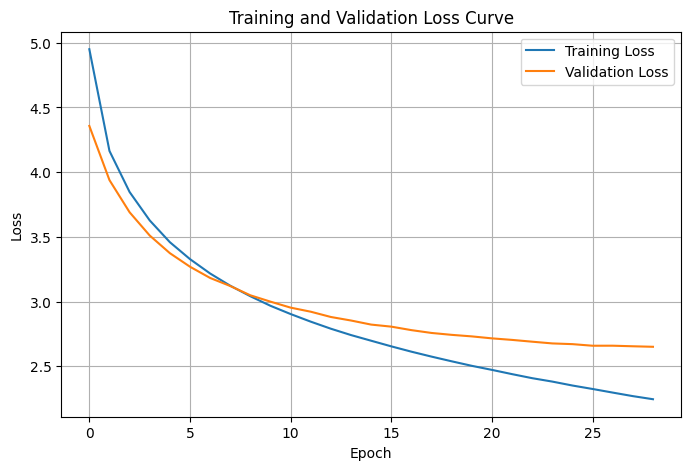

In [ ]:
from tqdm import tqdm

def save_checkpoint(epoch, model, optimizer, loss_list, path):
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss_list': loss_list
    }, path)
    print(f"Checkpoint saved at epoch {epoch}")

def load_checkpoint(path):
    checkpoint = torch.load(path)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    return checkpoint['epoch'], checkpoint['loss_list']

# Load checkpoint if available
start_epoch = 0
loss_list = []
if os.path.exists(checkpoint_path):
    start_epoch, loss_list = load_checkpoint(checkpoint_path)
    print(f"Resuming training from epoch {start_epoch}")

def validate(model, val_loader, criterion, device):
    model.eval()  # Set the model to evaluation mode
    total_val_loss = 0

    with torch.no_grad():
        val_loader_tqdm = tqdm(val_loader, desc="Validating", unit="batch", leave=False)
        for images, captions,_ in val_loader_tqdm:
            images, captions = images.to(device), captions.to(device)

            # Forward pass
            outputs, _ = model(images, captions[:, :-1])
            
            # Calculate loss
            loss = criterion(outputs.reshape(-1, outputs.size(2)), captions[:, 1:].reshape(-1))
            
            total_val_loss += loss.item()
            val_loader_tqdm.set_postfix(val_loss=loss.item())

    avg_val_loss = total_val_loss / len(val_loader)
    return avg_val_loss

# Training and Validation Loop with Early Stopping
train_loss_list = []
val_loss_list = []

# Early stopping parameters
patience = 3
min_delta = 0.01  # Minimum improvement in validation loss
early_stop_counter = 0
best_val_loss = float('inf')
best_model_path = "best.pth"

for epoch in range(start_epoch, num_epochs):
    model.train()
    total_train_loss = 0

    # Training loop with progress bar
    train_loader_tqdm = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", unit="batch")
    for images, captions,_ in train_loader_tqdm:
        images, captions = images.to(device), captions.to(device)

        optimizer.zero_grad()

        with torch.cuda.amp.autocast():
            outputs, _ = model(images, captions[:, :-1])
            loss = criterion(outputs.reshape(-1, outputs.size(2)), captions[:, 1:].reshape(-1))

        # Backpropagation and optimization
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        total_train_loss += loss.item()
        train_loader_tqdm.set_postfix(train_loss=loss.item())

    avg_train_loss = total_train_loss / len(train_loader)
    train_loss_list.append(avg_train_loss)
    print(f"Epoch [{epoch+1}/{num_epochs}] - Training Loss: {avg_train_loss:.4f}")

    # Validation step
    avg_val_loss = validate(model, val_loader, criterion, device)
    val_loss_list.append(avg_val_loss)
    print(f"Epoch [{epoch+1}/{num_epochs}] - Validation Loss: {avg_val_loss:.4f}")

    # Check improvement in validation loss
    improvement = best_val_loss - avg_val_loss
    if improvement > min_delta:
        best_val_loss = avg_val_loss
        save_checkpoint(epoch + 1, model, optimizer, train_loss_list, best_model_path)
        print(f"New best model saved with validation loss: {best_val_loss:.4f}")
        early_stop_counter = 0  # Reset the early stopping counter
    else:
        early_stop_counter += 1
        print(f"No significant improvement in validation loss for {early_stop_counter} epochs. Improvement: {improvement:.4f}")

    # Early stopping condition
    if early_stop_counter >= patience:
        print("Early stopping triggered due to no significant improvement.")
        break

    # Save the checkpoint at every epoch
    save_checkpoint(epoch + 1, model, optimizer, train_loss_list, checkpoint_path)

# Plot the loss curves
plt.figure(figsize=(8, 5))
plt.plot(train_loss_list, label='Training Loss')
plt.plot(val_loss_list, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Curve')
plt.legend()
plt.grid()
plt.show()


In [11]:
def generate_caption_with_attention(model, image, vocab, max_length=20):
    """
    Generate a caption for an image using the trained model with attention visualization.
    """
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():
        # Encode the image
        encoder_outputs = model.encoder(image.unsqueeze(0))  # Shape: (1, num_pixels, encoder_dim)
        caption = [vocab.stoi["<SOS>"]]
        attention_weights = []

        # Initialize hidden and cell states for the LSTM
        h, c = torch.zeros(1, 1, encoder_outputs.size(2)).to(image.device), torch.zeros(1, 1, encoder_outputs.size(2)).to(image.device)

        for t in range(max_length):
            # Prepare the input for the decoder
            input_caption = torch.tensor([caption[-1]]).unsqueeze(0).to(image.device)  # Shape: (1, 1)
            embeddings = model.decoder.embedding(input_caption)  # Shape: (1, 1, embed_size)

            # Compute attention and context vector
            context, alpha = model.decoder.attention(encoder_outputs, h[-1])  # (1, encoder_dim), (1, num_pixels)
            attention_weights.append(alpha.squeeze(0))  # Append attention weights

            # Concatenate embeddings and context for LSTM input
            lstm_input = torch.cat([embeddings.squeeze(1), context], dim=1).unsqueeze(0)  # Shape: (1, 1, embed_size + encoder_dim)

            # Pass through LSTM
            _, (h, c) = model.decoder.lstm(lstm_input, (h, c))

            # Generate output predictions
            outputs = model.decoder.fc(h[-1])  # Shape: (1, vocab_size)
            predicted_word_idx = outputs.argmax(dim=1).item()

            # Append the predicted word to the caption
            caption.append(predicted_word_idx)
            if predicted_word_idx == vocab.stoi["<EOS>"]:
                break

        attention_weights = torch.stack(attention_weights, dim=0)  # Combine attention weights
        decoded_caption = [vocab.itos[idx] for idx in caption]
        return decoded_caption, attention_weights


import torch
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F

import math

def visualize_attention_with_overlay(image, decoded_caption, attention_weights):
    """
    Visualize attention weights by overlaying them on the input image for each word in the caption.
    
    Args:
        image: Tensor of shape (3, H, W).
        decoded_caption: List of strings representing the caption.
        attention_weights: Tensor of shape (seq_length, num_pixels).
    """
    # Preprocess the image for visualization
    image = image.cpu().numpy().transpose(1, 2, 0)  # (H, W, C)
    image = (image * np.array([0.229, 0.224, 0.225])) + np.array([0.485, 0.456, 0.406])  # De-normalize
    image = np.clip(image, 0, 1)  # Clip to valid range [0, 1]

    # Reshape attention weights to (seq_length, 7, 7)
    seq_length, num_pixels = attention_weights.shape
    grid_size = int(num_pixels**0.5)
    if grid_size * grid_size != num_pixels:
        raise ValueError("Attention weights cannot be reshaped to a square grid.")
    attention_weights = attention_weights.view(seq_length, grid_size, grid_size)  # Reshape to (seq_length, 7, 7)

    # Resize attention maps to match image dimensions (224x224)
    attention_weights_resized = []
    for alpha in attention_weights:
        alpha_resized = F.interpolate(alpha.unsqueeze(0).unsqueeze(0), size=(image.shape[0], image.shape[1]), mode='bilinear', align_corners=False)
        attention_weights_resized.append(alpha_resized.squeeze().cpu().detach().numpy())

    # Calculate number of rows and columns for the subplot grid
    num_cols = math.ceil(seq_length / 2)  # Split into two rows
    num_rows = 2  # Always two rows

    # Create a figure for visualization
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(num_cols * 5, num_rows * 5))  # Adjust figure size for larger images
    axes = axes.flatten()  # Flatten axes for easier indexing

    for t, ax in enumerate(axes):
        if t < seq_length:
            # Overlay the attention map on the image
            ax.imshow(image)  # Display the original image
            ax.imshow(attention_weights_resized[t], cmap='jet', alpha=0.6)  # Overlay attention weights
            ax.set_title(decoded_caption[t], fontsize=12)  # Larger font size for titles
            ax.axis('off')
        else:
            ax.axis('off')  # Turn off any extra subplot

    # Adjust spacing between subplots
    plt.subplots_adjust(wspace=0.5, hspace=0.5)  # Increase spacing to reduce overlap
    plt.show()


In [12]:
import torch
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction

# Load the saved model
checkpoint_path = "best.pth"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Restore the model and optimizer
checkpoint = torch.load(checkpoint_path, map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])
model = model.to(device)
model.eval()
print(f"Model loaded from {checkpoint_path}")

Model loaded from best.pth


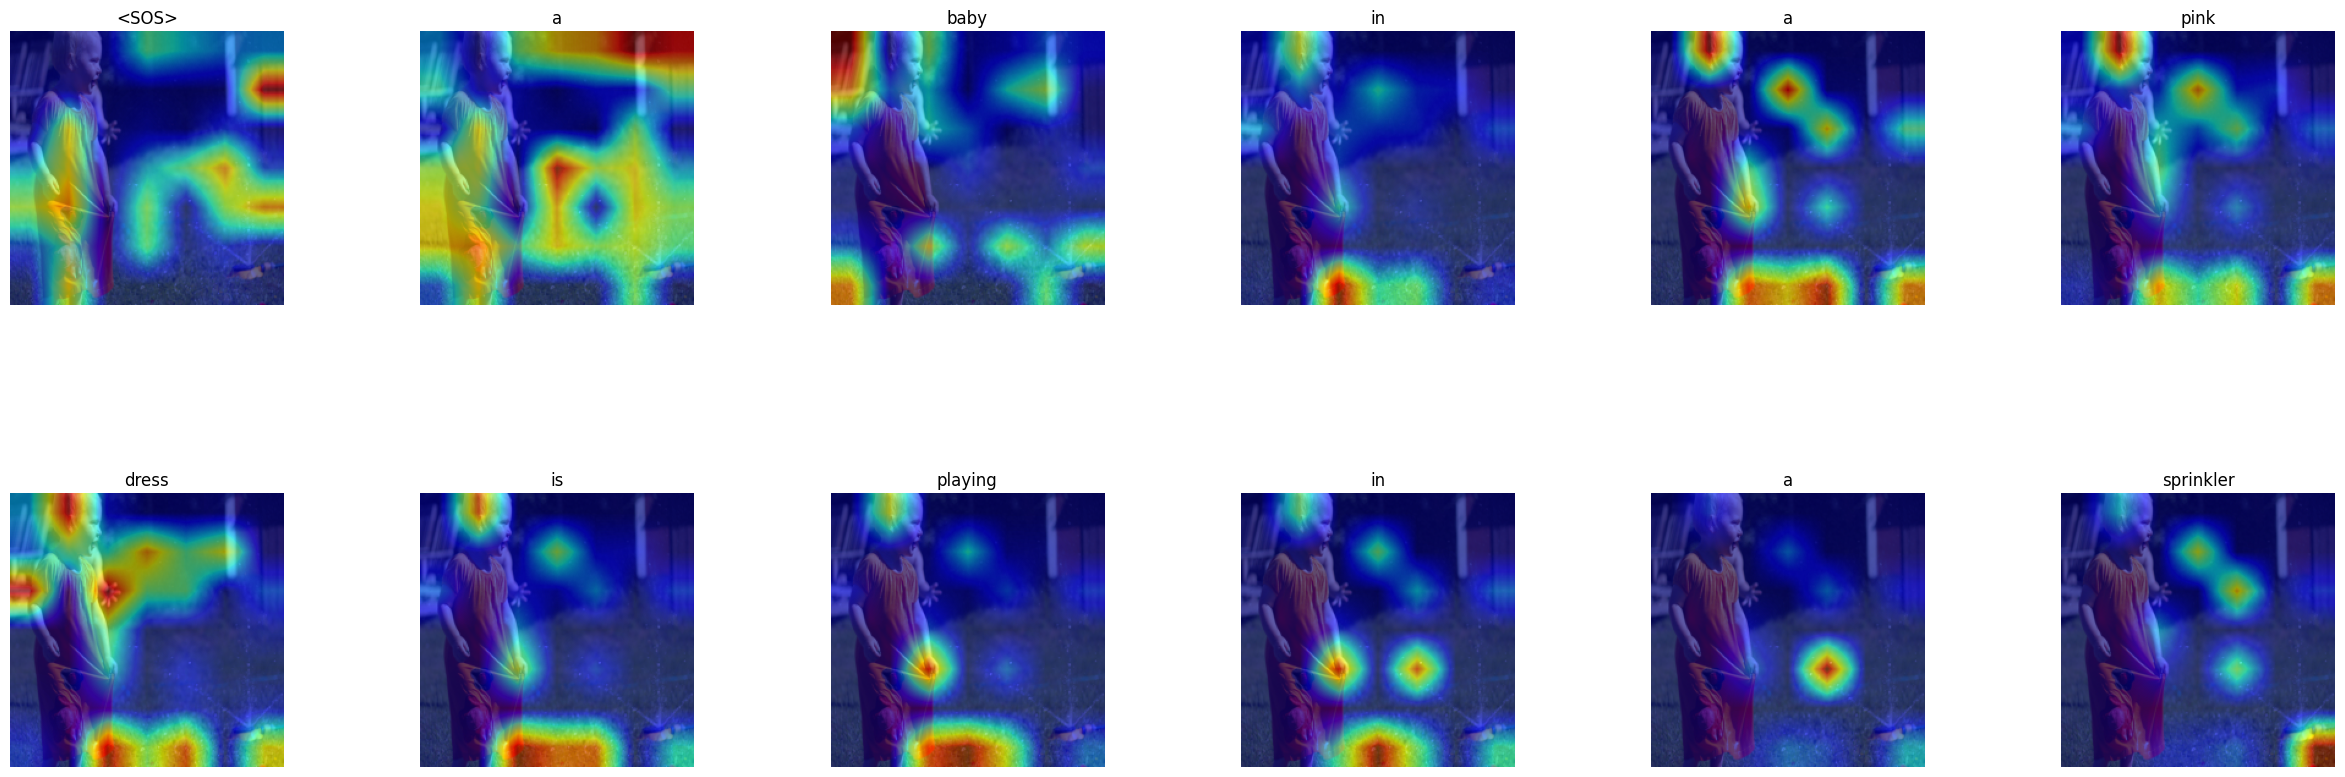

In [13]:
# Load a single image and preprocess
image_path = "/home/sazid/Documents/semester3/DND Ass 2/adityajn105/flickr8k/versions/1/Images/3767841911_6678052eb6.jpg"
image = Image.open(image_path).convert("RGB")
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
image_tensor = transform(image).to(device)

# Generate caption and attention weights
decoded_caption, attention_weights = generate_caption_with_attention(model, image_tensor, dataset.vocab)

# Visualize attention
visualize_attention_with_overlay(image_tensor, decoded_caption, attention_weights)


### 2.3. Evaluation on test set

Evaluate your trained model on the test set. Use the BLEU score as your metric: torchtext.data.metrics.bleu_score(...)

You may try **BLEU-1, 2** and **3**.

In [15]:
from torchtext.data.metrics import bleu_score
from tqdm import tqdm

def evaluate_bleu(model, test_loader, vocab, device, max_len=30):
    """
    Evaluates BLEU scores (BLEU-1, BLEU-2, BLEU-3) for the model on the test dataset.

    Args:
        model: Trained image captioning model.
        test_loader: DataLoader for the test dataset.
        vocab: Vocabulary used in the dataset.
        device: Device to run the evaluation on ('cuda' or 'cpu').
        max_len: Maximum caption length for generation.

    Returns:
        Dictionary of BLEU scores.
    """
    model.eval()  # Set model to evaluation mode
    references = []
    hypotheses = []

    with torch.no_grad():
        for images, target_captions, all_captions in tqdm(test_loader, desc="Evaluating BLEU"):
            images = images.to(device)

            # Generate captions for all images in the batch
            generated_captions = []
            for img in images:
                # Generate caption for each image
                caption, _ = generate_caption_with_attention(model, img, vocab, max_length=max_len)
                generated_captions.append(caption)

            # Process captions and prepare references and hypotheses
            for i in range(len(target_captions)):
                # Reference captions (ground truth), could be multiple
                ref = []
                for target_caption in all_captions[i]:  # This handles all captions for the i-th image
                    ref_caption = [
                        vocab.index_to_vocab[token] for token in target_caption
                        if token not in [vocab.stoi['<PAD>'], vocab.stoi['<SOS>'], vocab.stoi['<EOS>']]
                    ]
                    if len(ref_caption) > 0:
                        ref.append(ref_caption)  # Add valid reference caption

                # Generated caption (hypothesis)
                hyp = [word for word in generated_captions[i] if word not in ['<PAD>', '<SOS>', '<EOS>']]

                # Append if both reference and hypothesis are valid
                if len(hyp) > 0 and len(ref) > 0:
                    references.append(ref)
                    hypotheses.append(hyp)

    # Calculate BLEU scores
    bleu1 = bleu_score(hypotheses, references, max_n=1, weights=[1.0])
    bleu2 = bleu_score(hypotheses, references, max_n=2, weights=[0.5, 0.5])
    bleu3 = bleu_score(hypotheses, references, max_n=3, weights=[1/3, 1/3, 1/3])

    return {"BLEU-1": bleu1, "BLEU-2": bleu2, "BLEU-3": bleu3}

# Run BLEU evaluation
bleu_scores = evaluate_bleu(model, test_loader, dataset.vocab, device)
print("BLEU Scores:", bleu_scores)


Evaluating BLEU: 100%|██████████| 64/64 [00:35<00:00,  1.80it/s]


BLEU Scores: {'BLEU-1': 0.7464808821678162, 'BLEU-2': 0.5975880026817322, 'BLEU-3': 0.4557054042816162}


### 2.4. Load an existing Image Captioning model
Feel free to choose any pre-trained image captioning model. For simplicity, try choosing a model already trained on Flickr8k.

### 2.5 Evaluate the chosen pre-trained captioning model on the test set
Use the same metrics chosen on step **2.3**.

In [ ]:
import torch
from transformers import BlipProcessor, BlipForConditionalGeneration
from torchtext.data.metrics import bleu_score
from tqdm import tqdm

# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load the BLIP model and processor
model_name = "Salesforce/blip-image-captioning-base"
processor = BlipProcessor.from_pretrained(model_name)

Blip_model = BlipForConditionalGeneration.from_pretrained(model_name).to(device)

# Function to generate captions using BLIP
def generate_caption_blip(image, max_length=30):
    """
    Generates a caption for a single image using the BLIP model.

    Args:
        image: Normalized image tensor with shape (3, H, W).
        max_length: Maximum length of the generated caption.

    Returns:
        Generated caption as a list of words.
    """
    # De-normalize the image
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1).to(image.device)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1).to(image.device)
    image = image * std + mean  # De-normalize the image to range [0, 1]
    
    # Ensure values are clamped to [0, 1]
    image = torch.clamp(image, 0, 1)

    # Prepare the image for BLIP
    image = image.unsqueeze(0).to(device)  # Add batch dimension and move to device
    inputs = processor(images=image, return_tensors="pt", do_rescale=False).to(device)
    output_ids = Blip_model.generate(**inputs, max_length=max_length)
    caption = processor.decode(output_ids[0], skip_special_tokens=True)
    return caption.split()

# BLEU score evaluation function
def evaluate_bleu_blip(test_loader, vocab, device, max_len=30):
    """
    Evaluates BLEU scores for BLIP model on the dataset.

    Args:
        test_loader: DataLoader for the test dataset.
        vocab: Vocabulary object.
        device: Device to run the evaluation on ('cuda' or 'cpu').
        max_len: Maximum caption length for generation.

    Returns:
        Dictionary of BLEU scores.
    """
    Blip_model.eval()  # Set model to evaluation mode
    references = []
    hypotheses = []

    with torch.no_grad():
        for images, target_captions, all_captions in tqdm(test_loader, desc="Evaluating BLEU"):
            images = images.to(device)

            # Generate captions for all images in the batch
            generated_captions = []
            for img in images:
                caption = generate_caption_blip(img, max_length=max_len)
                generated_captions.append(caption)

            # Process references and hypotheses
            for i in range(len(target_captions)):
                # Reference captions (ground truth), could be multiple for each image
                ref = []
                for target_caption in all_captions[i]:  # Handling multiple reference captions
                    ref_caption = [
                        vocab.index_to_vocab[token] for token in target_caption
                        if token not in [vocab.stoi["<PAD>"], vocab.stoi["<SOS>"], vocab.stoi["<EOS>"]]
                    ]
                    if len(ref_caption) > 0:
                        ref.append(ref_caption)  # Add valid reference caption

                # Generated caption (hypothesis)
                hyp = [word for word in generated_captions[i] if word not in ["<PAD>", "<SOS>", "<EOS>"]]

                # Append if both reference and hypothesis are valid
                if len(hyp) > 0 and len(ref) > 0:
                    references.append(ref)
                    hypotheses.append(hyp)

    # Calculate BLEU scores
    bleu1 = bleu_score(hypotheses, references, max_n=1, weights=[1.0])
    bleu2 = bleu_score(hypotheses, references, max_n=2, weights=[0.5, 0.5])
    bleu3 = bleu_score(hypotheses, references, max_n=3, weights=[1/3, 1/3, 1/3])

    return {"BLEU-1": bleu1, "BLEU-2": bleu2, "BLEU-3": bleu3}

# the `test_loader` and `dataset` are already set up
bleu_scores = evaluate_bleu_blip(test_loader, dataset.vocab, device)
print("BLEU Scores:", bleu_scores)


Evaluating BLEU: 100%|██████████| 64/64 [05:12<00:00,  4.88s/it]


BLEU Scores: {'BLEU-1': 0.7016332069593967, 'BLEU-2': 0.5308611902327588, 'BLEU-3': 0.37824627566389546}


# 3. COMPARISON
Compare the performance of the two models using **BLEU-1, 2** and **3**. Show some visualizations of predictions from both models. Justify their differences. How would you improve your own custom model?

| Models        | BLEU-1  | BLEU-2  | BLEU-3  |
|---------------|---------|---------|---------|
| Custom model  | 74.64%  | 59.75%  | 45.57%  |
| BLIP model    | 70.16%  | 53.08%  | 37.82%  |

To improve the custom model, I would consider the following enhancements:

1. **Use a more advanced attention mechanism**: Implementing a multi-head attention mechanism similar to the one used in the Transformer architecture could improve the model's ability to focus on different parts of the image simultaneously.

2. **Increase the model capacity**: Adding more layers to the LSTM or using a more complex sequence model like GRU or Transformer for the decoder could help the model learn better representations.

3. **Learning rate scheduling**: Using learning rate schedulers like ReduceLROnPlateau or CosineAnnealingLR can help in better convergence of the model.

4. **Ensemble methods**: Combining predictions from multiple models (ensembles) can often lead to better performance.

5. **Pre-trained embeddings**: Using pre-trained word embeddings like GloVe or FastText for the decoder can provide a better starting point for the model.

6. **Hyperparameter tuning**: Systematically tuning hyperparameters such as learning rate, batch size, and the number of layers can lead to better performance.

7. **Use of beam search**: Implementing beam search during inference can improve the quality of generated captions by considering multiple possible sequences.


By implementing these improvements, the custom model's performance can be enhanced, potentially leading to better BLEU scores and more accurate image captions.

The differences in performance between the custom model and the BLIP model can be attributed to several factors:

1. **Fine-tuning**: he BLIP model was not fine-tuned on Flickr8k, which means it may not be as well-adapted to the specific images and captions in this dataset.

2. **Architecture**: The BLIP model, while powerful, is a more general-purpose model and may not be as optimized for the specific task of image captioning without fine-tuning.

3. **Training Data**: The custom model was trained specifically on the Flickr8k dataset, which means it has seen and learned from the exact data it is being evaluated on. The BLIP model, on the other hand, was trained on a broader dataset and may not have seen similar images or captions during its training.

4. **Attention Mechanism**: The BLIP model's attention mechanism, while sophisticated, may not be as finely tuned for the specific task of image captioning on the Flickr8k dataset.

5. **Vocabulary**: The custom model's vocabulary is built specifically from the Flickr8k dataset, ensuring that it can generate captions using the most relevant and frequently occurring words in this dataset. The BLIP model's vocabulary is more general and may not include some of the specific terms used in the Flickr8k captions.

Overall, the custom model's fine-tuning, specialized architecture, and targeted training data contribute to its superior performance on the Flickr8k dataset compared to the BLIP model, which was not fine-tuned for this specific task.

In [ ]:
def visualize_predictions(model, test_loader, vocab, num_samples=3):
    from transformers import BlipProcessor, BlipForConditionalGeneration

    # Load the pre-trained BLIP model
    processor = BlipProcessor.from_pretrained("Salesforce/blip-image-captioning-base")
    # blip_model = BlipForConditionalGeneration.from_pretrained("Salesforce/blip-image-captioning-base").to(device)

    # Define the unnormalize transform
    unnormalize = transforms.Normalize(
        mean=[-0.485 / 0.229, -0.456 / 0.224, -0.406 / 0.225],
        std=[1 / 0.229, 1 / 0.224, 1 / 0.225]
    )

    for images, captions,_ in list(test_loader)[:num_samples]:
        images = images.to(device)
        for i in range(len(images)):
            plt.figure()
            image_tensor = images[i].cpu()
            
            # Unnormalize the image
            image_tensor = unnormalize(image_tensor)
            image_tensor = torch.clamp(image_tensor, 0, 1)  # Clip values to be in the valid range [0, 1]

            image = transforms.ToPILImage()(image_tensor)
            plt.imshow(image)
            plt.axis('off')

            # Generate caption using your custom model
            generated_caption,_ = generate_caption_with_attention(model, images[i], vocab)
            # Filter out the <SOS> and <EOS> tokens by checking if the token is not one of the special tokens
            filtered_caption = [word for word in generated_caption if word not in {"<SOS>", "<EOS>", "<UNK>"}]
            
            generated_caption = " ".join(filtered_caption)
            print(f"Custom Model Caption: {generated_caption}")
            custom_caption = decode_caption(captions[i].tolist(), vocab)
            print(f"Original Caption: {custom_caption}")
            

            # Generate caption using the BLIP model
            inputs = processor(images=image, return_tensors="pt").to(device)
            with torch.no_grad():
                outputs = Blip_model.generate(**inputs)
            blip_caption = processor.decode(outputs[0], skip_special_tokens=True)
            print(f"BLIP Model Caption: {blip_caption}")
            
            plt.title(f"Custom: {generated_caption}\nBLIP: {blip_caption}\nOriginal: {custom_caption}")
            plt.show()


visualize_predictions(model, test_loader, dataset.vocab)
